In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import gzip
import os
import pickle
from urllib.request import urlretrieve

import nengo
import nengo_dl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/version.py:32: UserWarning: This version of `nengo_dl` has not been tested with your `nengo` version (3.0.0.dev0). The latest fully supported version is 2.8.0.
  ((nengo.version.version,) + latest_nengo_version))


### Download MNIST data

In [94]:
# download MNIST dataset
urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz",
            "mnist.pkl.gz")
with gzip.open("mnist.pkl.gz") as f:
    (train_data, _), _, (test_data, _) = pickle.load(
        f, encoding="latin1")
np.random.shuffle(train_data)

n_epochs = 2

###### Important! Reshape [5000,784] to [5000,1,784]

In [95]:
train_data = train_data[:, None, :]
test_data = test_data[:, None, :]

In [99]:
train_data.shape

(50000, 1, 784)

In [100]:
test_data.shape

(10000, 1, 784)

### Params

In [6]:
n_in = 784
n_hidden = 64
minibatch_size = 50

### Network by Nengo-DL

In [43]:
with nengo.Network() as auto_net:
    # input
    nengo_a = nengo.Node(np.zeros(n_in))

    # first layer
    nengo_b = nengo.Ensemble(
        n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())

    # second layer
    nengo_c = nengo.Ensemble(
        n_in, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons,
        transform=nengo_dl.dists.Glorot())

    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)

In [51]:
# set initial neuron gains to 1 and biases to 0
for ens in auto_net.all_ensembles:
    ens.gain = nengo.dists.Choice([1])
    ens.bias = nengo.dists.Choice([0])

# disable synaptic filtering on all connections
for conn in auto_net.all_connections:
    conn.synapse = None

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               ##################################################################################################################################################################################################################################################################################################################| ETA: 0:00:00
Training finished in 0:00:24 (loss: 0.2176)                                    
Calculation finished in 0:00:01                                                
error: 0.22699942


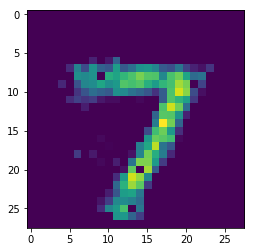

In [45]:
# define loss function (we could use the pre-defined
# `nengo_dl.obj.mse`, but we define it explicitly here
# for clarity)
#def loss(outputs, targets):
#    print(np.asarray(tf.square(outputs - targets)).shape)
#    return tf.reduce_mean(tf.square(outputs - targets))

def loss(outputs, targets):
    """ binary crossentropy
    """
    return tf.reduce_mean(tf.keras.backend.binary_crossentropy(
        target=targets, output=outputs))

with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    # sim.train automatically adds the necessary elements to the
    # graph and runs the training loop
    # note: the probe acts as the placeholder to feed in target values
    sim.train({nengo_a: train_data, p_c: train_data},
              tf.train.AdamOptimizer(1e-3),
              objective={p_c: loss}, n_epochs=n_epochs)

    # evaluate performance on test set
    error = sim.loss({nengo_a: test_data, p_c: test_data},
                     objective={p_c: loss})
    print("error:", error)

    # display example output
    sim.step(data={nengo_a: test_data[:minibatch_size]})
    plt.figure()
    plt.imshow(sim.data[p_c][0].reshape((28, 28)))

------------------
#### How about embedding layer?

In [96]:
max_rate = 100
amp = 1 / max_rate
dt = 0.001
presentation_time = 0.1

In [101]:
test_data[0].shape

(1, 784)

In [102]:
with nengo.Network() as auto_net2:
    # input
    #nengo_a  = nengo.Node(np.zeros(n_in))
    #out = nengo.Node(size_in=10)
    nengo_a = nengo.Node(
        nengo.processes.PresentInput(test_data[0], presentation_time),
        size_out=28 * 28)

    # first layer
    nengo_b = nengo.Ensemble(
        n_hidden, 1, neuron_type=nengo.SpikingRectifiedLinear(amplitude=amp))
    nengo.Connection(
        nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())

    # second layer
    nengo_c = nengo.Ensemble(
        n_in, 1, neuron_type=nengo.SpikingRectifiedLinear(amplitude=amp))
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons,
        transform=nengo_dl.dists.Glorot())

    # probes are used to collect data from the network
    p_b = nengo.Probe(nengo_b.neurons)
    p_c = nengo.Probe(nengo_c.neurons)
    #out_p = 
    #out_p_filt = nengo.Probe(out, synapse=nengo.Alpha(0.01))
    p_c_filt =  nengo.Probe(nengo_a, synapse=nengo.Alpha(0.01))

In [103]:
# set initial neuron gains to 1 and biases to 0
for ens in auto_net2.all_ensembles:
    ens.gain = nengo.dists.Choice([1])
    ens.bias = nengo.dists.Choice([0])

# disable synaptic filtering on all connections
for conn in auto_net2.all_connections:
    conn.synapse = None

In [104]:
x_train = {nengo_a : train_data[0][:, None, :],
           p_c_filt : train_data[1][:, None, :]}

In [105]:
x_test = {
    nengo_a: np.tile(test_data[0][:, None, :],
                 (1,int(presentation_time / dt), 1)),
    p_c_filt: np.tile(test_data[1][:, None, :],
                        (1,int(presentation_time / dt), 1))
}

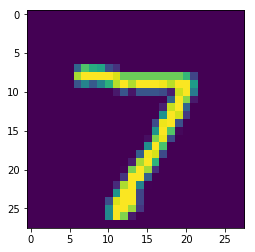

In [46]:
a = test_data[0].reshape(28,28)
plt.imshow(a)

In [85]:
train_data[0].shape

(1, 784)

In [106]:
x_train[nengo_a].shape

(1, 1, 784)

In [107]:
def loss(outputs, targets):
    """ binary crossentropy
    """
    return tf.reduce_mean(tf.keras.backend.binary_crossentropy(
        target=targets, output=outputs))


with nengo_dl.Simulator(auto_net2, minibatch_size=minibatch_size) as sim:
    #sim.train({nengo_a: x_train, p_c: x_train},
    sim.train(x_train,
              tf.train.AdamOptimizer(1e-3),
              objective={p_c: loss}, n_epochs=n_epochs)

    # evaluate performance on test set
    # error = sim.loss({nengo_a: test_data, p_c: test_data},
    error = sim.loss({nengo_a: x_test[p_c_filt][:minibatch_size], p_c: x_test[p_c_filt][:minibatch_size]},
                     objective={p_c: loss})
    print("error:", error)
    # display example output
    sim.step(data={nengo_a: x_test[p_c_filt][:minibatch_size]})
    plt.figure()
    plt.imshow(sim.data[p_c][0].reshape((28, 28)))

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|#########Constructing graph: creating base arrays (200%)########################################################################| ETA: 0:00:00

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/simulator.py:131: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


Construction finished in 0:00:01                                               
Training finished in ETA:  --:--:-- (loss: ---)                                


/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/simulator.py:529: UserWarning: Training for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  "Training for one timestep, but the network contains "


ValidationError: data: Size of minibatch (1) for <Node (unlabeled) at 0x7fc118557ac8> data less than Simulation `minibatch_size` (50)

In [159]:
# run
n_presentations = 50
with nengo_dl.Simulator(auto_net2, dt=dt) as sim:
    sim.run(n_presentations * presentation_time)

    # check classification error
    step = int(presentation_time / dt)
    output = sim.data[p_c_filt][step - 1::step] 

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|#                        Constructing graph                          | 0:00:00

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/simulator.py:131: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


Construction finished in 0:00:01                                               ##################################################################################################################################################################################################################################################################################################################| ETA: 0:00:00
Simulation finished in 0:00:04                                                 


In [164]:
x_test[nengo_a].shape

(1, 100, 784)

In [165]:
allimage.shape

(28, 280)

In [170]:
ccc = x_test[nengo_a].reshape(-1, 28, 28, 1)[20]
ccc.shape

(28, 28, 1)

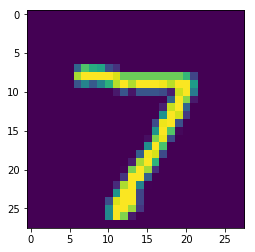

In [171]:
plt.imshow(ccc[:,:,0])

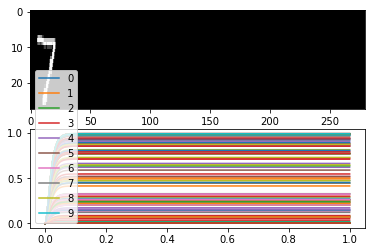

In [160]:
n_plots = 10
plt.figure()

plt.subplot(2, 1, 1)
images = x_test[nengo_a].reshape(-1, 28, 28, 1)[::step]
ni, nj, nc = images[0].shape
allimage = np.zeros((ni, nj * n_plots, nc), dtype=images.dtype)
for i, image in enumerate(images[:n_plots]):
    allimage[:, i * nj:(i + 1) * nj] = image
if allimage.shape[-1] == 1:
    allimage = allimage[:, :, 0]
plt.imshow(allimage, aspect='auto', interpolation='none', cmap='gray')

plt.subplot(2, 1, 2)
plt.plot(sim.trange()[:n_plots * step], sim.data[p_c_filt][:n_plots * step])
plt.legend(['%d' % i for i in range(10)], loc='best');

In [63]:
sim.trange()

array([0.001])

In [64]:
sim.data[p_b].shape

(50, 1, 64)

In [65]:
bottleneck_layer = np.squeeze(sim.data[p_b])

#### clustering to bottleneck layer

In [67]:
! pip install sklearn

    100% |████████████████████████████████| 6.7MB 1.1MB/s ta 0:00:011
    100% |████████████████████████████████| 286kB 3.4MB/s ta 0:00:01
  Stored in directory: /home/kurihana/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [81]:
from sklearn.manifold import TSNE

Dimension reduction by TSNE

In [82]:
# do tsne
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(bottleneck_layer)

In [105]:
from sklearn.decomposition import PCA

Apply PCA

In [106]:
# Compute the clusters
pca = PCA(n_components=n_cluster)
features = pca.fit_transform(bottleneck_layer)

Get lables for test data

In [70]:
with gzip.open("mnist.pkl.gz") as f:
    (_, _), _, (test_data, test_label) = pickle.load(
        f, encoding="latin1")

In [71]:
test_label.shape

(10000,)

In [73]:
test_data.shape

(10000, 784)

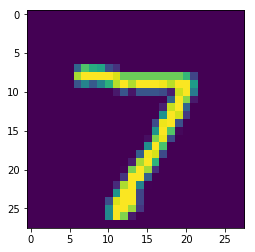

In [74]:
plt.imshow(test_data[0].reshape(28,28))

Let's visualize

1 t-SNE

In [97]:
import matplotlib  
#.colors #import Colormap
def _get_colors(n=-1, cmap_name='jet'):
    # colormap
    cmap = matplotlib.cm.get_cmap(cmap_name, n)
    colors = []
    for idx, i in enumerate(range(cmap.N)):
        rgb = cmap(i)[:3]
        #print(idx, matplotlib.colors.rgb2hex(rgb))
        colors += [matplotlib.colors.rgb2hex(rgb)]
    return colors

Text(0.5, 1.0, 't-SNE to bottleneck layer')

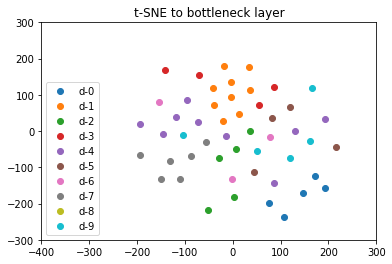

In [115]:
n_cluster = 10
colors = _get_colors(n=n_cluster)
for i in range(n_cluster):
    cidx = np.where(test_label[:50] == i)
    plt.scatter(digits_proj[cidx,0], digits_proj[cidx,1], label='d-'+str(i))
plt.legend(ncol=1, loc='lower left')
plt.ylim(-300,300);plt.xlim(-400,300)
plt.title('t-SNE to bottleneck layer')

2 PCA

Text(0.5, 1.0, 'PCA to bottleneck layer')

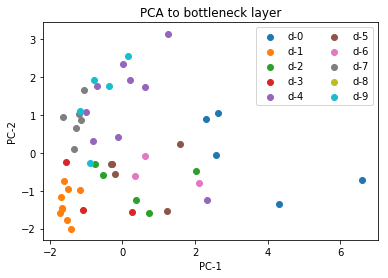

In [117]:
n_cluster = 10
colors = _get_colors(n=n_cluster)
for i in range(n_cluster):
    cidx = np.where(test_label[:50] == i)
    plt.scatter(features[cidx,0], features[cidx,1], label='d-'+str(i))
plt.legend(ncol=2, loc='upper right')
#plt.ylim(-300,300);plt.xlim(-400,300)
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('PCA to bottleneck layer')

#### Multiple time steps not temporal 

In [108]:
def conv_layer(x, *args, activation=True, **kwargs):
    # create a Conv2D transform with the given arguments
    conv = nengo.Convolution(*args, channels_last=False, **kwargs)

    if activation:
        # add an ensemble to implement the activation function
        layer = nengo.Ensemble(conv.output_shape.size, 1).neurons
    else:
        # no nonlinearity, so we just use a node
        layer = nengo.Node(size_in=conv.output_shape.size)

    # connect up the input object to the new layer
    nengo.Connection(x, layer, transform=conv)

    # print out the shape information for our new layer
    print("LAYER")
    print(conv.input_shape.shape, "->", conv.output_shape.shape)

    return layer, conv

In [110]:
dt = 0.001  # simulation timestep
presentation_time = 0.1  # input presentation time
max_rate = 100  # neuron firing rates
# neuron spike amplitude (scaled so that the overall output is ~1)
amp = 1 / max_rate
# input image shape
input_shape = (1, 28, 28)
n_parallel = 2  # number of parallel network repetitions

with nengo.Network(seed=0) as net:
    # set up the default parameters for ensembles/connections
    #nengo_loihi.add_params(net)
    net.config[nengo.Ensemble].neuron_type = (
        nengo.SpikingRectifiedLinear(amplitude=amp))
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None

    # the input node that will be used to feed in input images
    inp = nengo.Node(
        nengo.processes.PresentInput(test_data[0], presentation_time),
        size_out=28 * 28)

    # the output node provides the 10-dimensional classification
    out = nengo.Node(size_in=10)

    # build parallel copies of the network
    for _ in range(n_parallel):
        layer, conv = conv_layer(
            inp, 1, input_shape, kernel_size=(1, 1),
            init=np.ones((1, 1, 1, 1)))
        # first layer is off-chip to translate the images into spikes
       # net.config[layer.ensemble].on_chip = False
        layer, conv = conv_layer(layer, 6, conv.output_shape,
                                 strides=(2, 2))
        layer, conv = conv_layer(layer, 24, conv.output_shape,
                                 strides=(2, 2))
        nengo.Connection(layer, out, transform=nengo_dl.dists.Glorot())

    out_p = nengo.Probe(out)
    out_p_filt = nengo.Probe(out, synapse=nengo.Alpha(0.01))

LAYER
(1, 28, 28) -> (1, 28, 28)
LAYER
(1, 28, 28) -> (6, 13, 13)
LAYER
(6, 13, 13) -> (24, 6, 6)
LAYER
(1, 28, 28) -> (1, 28, 28)
LAYER
(1, 28, 28) -> (6, 13, 13)
LAYER
(6, 13, 13) -> (24, 6, 6)
